In [1]:
import sys
sys.path.append('../')
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
import os
import torch.optim as optim
import numpy as np
from utils.__init__ import *
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from utils.metrics import calculate_metrics

torch.Size([64, 1, 224, 224]) torch.Size([64, 1, 224, 224])
tensor(1.) tensor(0.)
tensor([0., 1.])


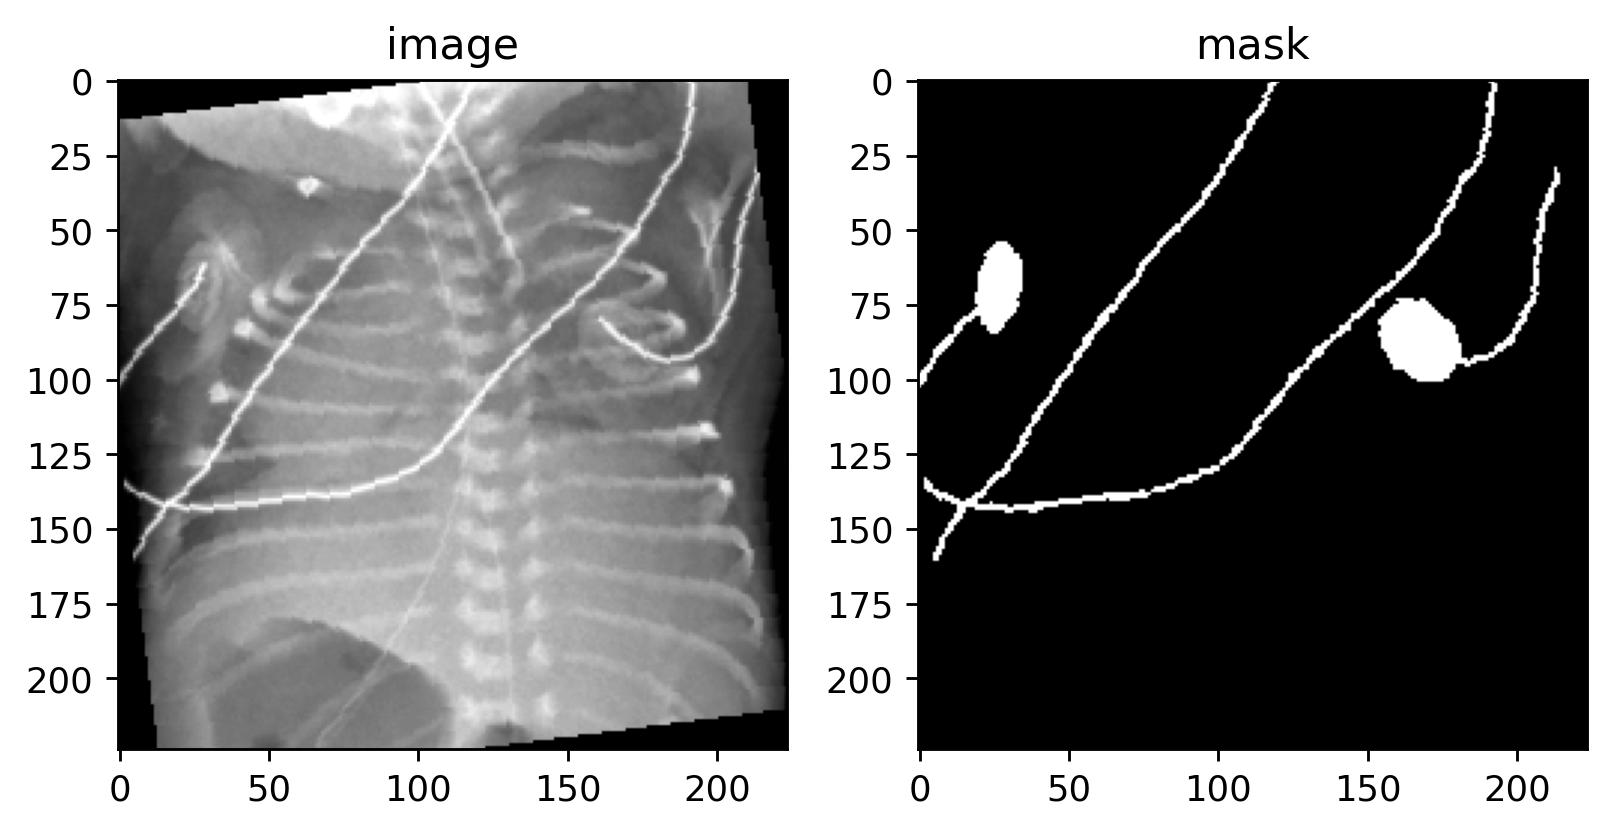

In [2]:
tr_img_dir = '/mnt/HDD/chest-seg/dataset/train_img'
tr_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
vl_img_dir = '/mnt/HDD/chest-seg/dataset/train_img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.RandomResizedCrop(512, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
        # transforms.RandomCrop(size = (224,224), pad_if_needed=True, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기와 대비 조정
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

# Dataset and DataLoader setup
train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform=transform['train'],
    testing=False,
)

valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transform['valid'],
    testing=True,  # Disables random transformations for validation
    seed = 627
)
tr_batch, vl_batch = 64, 64
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    print(images.max(), images.min())
    print(masks.unique())
    train_plotting(images, masks)
    break

# for images, masks, paths in valid_loader:
#     print(images.shape, masks.shape)
#     train_plotting(images, masks)
#     break


In [3]:
import sys 
sys.path.append('../')
from model.load_model import select_segmentation_models
import torch.optim as optim
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = select_segmentation_models(
    model_name = 'swinunet',
    pretrained= False,
    path = None,
    device = device
).load_model()
            
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss().to(device)
metrics = {
    't_bce':[],
    'v_bce':[],
    't_acc':[],
    'v_acc':[],
    't_iou':[],
    'v_iou':[],
}
model

SwinUNet(
  (patch_embed): PatchEmbedding(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Encoder(
    (enc_swin_blocks): ModuleList(
      (0): SwinBlock(
        (swtb1): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=32, out_features=96, bias=True)
            (proj): Linear(in_features=32, out_features=32, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GELU(approximate='none')
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=32, bias=True)
          )
        )
        (swtb2): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_aff

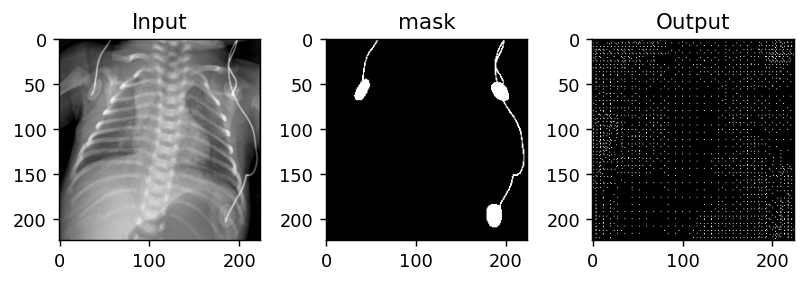

####################################################################################################
Train - BCE LOSS : 0.4743516892194748 | ACC : 0.8635139316320419 | mIoU : 0.018588028149679303
Valid - BCE LOSS : 0.3805081881582737 | ACC : 0.9448975771665573 | mIoU : 0.009750131168402731 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.3438507728278637 | ACC : 0.9593186527490616 | mIoU : 0.0041858752083498985
Valid - BCE LOSS : 0.2971136160194874 | ACC : 0.9688272699713707 | mIoU : 0.0011250761453993618 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.2754785493016243 | ACC : 0.9709185659885406 | mIoU : 0.0007226140951388516
Valid - BCE L

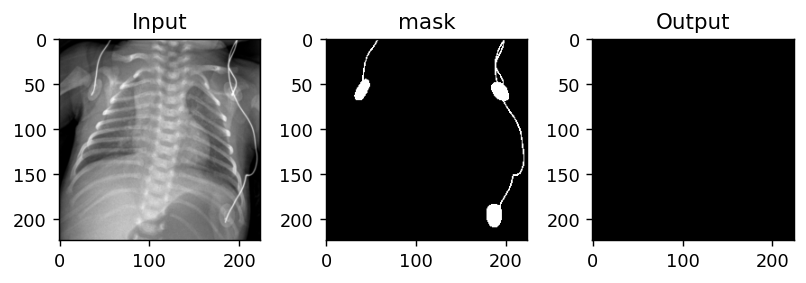

####################################################################################################
Train - BCE LOSS : 0.1849685162305832 | ACC : 0.9737893119454384 | mIoU : 7.595272109028883e-06
Valid - BCE LOSS : 0.17934770323336124 | ACC : 0.970967136323452 | mIoU : 0.0 

####################################################################################################


In [4]:
save_path = '/mnt/HDD/chest-seg_models/swin-unet'
os.makedirs(save_path, exist_ok=True)
for epoch in range(500):
    t_losses,t_accs,t_ious, v_losses,v_accs,v_ious = 0,0,0,0,0,0
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model.forward(images).to(device)
        
        # BCE Logistic Loss
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        t_losses += loss.cpu().detach().item()
        
        # mIoU & ACC 계산
        iou, acc = calculate_metrics(outputs, masks, threshold=0.5)
        t_ious += iou
        t_accs += acc
        
    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### inference
            outputs = model.forward(images.to(device)).to(device)  # 3+1ch
            
            loss = loss_fn(outputs, masks)
            v_losses += loss.cpu().detach().item()
            # mIoU & ACC 계산
            iou, acc = calculate_metrics(outputs, masks, threshold=0.5)
            v_ious += iou
            v_accs += acc
            
            
    if epoch % 5 == 0:
        save_validation(images, masks, (outputs > 0.5).int(), epoch, save_dir = save_path)
    #     save_model(model, optimizer, epoch, save_dir = save_path)
    #     save_loss(metrics, save_dir = save_path)

    metrics['t_bce'].append(t_losses / len(train_loader))
    metrics['v_bce'].append(v_losses / len(valid_loader))
    metrics['t_acc'].append(t_accs / len(train_loader))
    metrics['v_acc'].append(v_accs / len(valid_loader))
    metrics['t_iou'].append(t_ious / len(train_loader))
    metrics['v_iou'].append(v_ious / len(valid_loader))

    print("#" * 100)    
    print(f"Train - BCE LOSS : {metrics['t_bce'][-1]} | ACC : {metrics['t_acc'][-1]} | mIoU : {metrics['t_iou'][-1]}")
    print(f"Valid - BCE LOSS : {metrics['v_bce'][-1]} | ACC : {metrics['v_acc'][-1]} | mIoU : {metrics['v_iou'][-1]} \n")
    print("#" * 100)
    


In [6]:
# model weight에서 dead weight 파라미터 개수 확인 
# 출력 : dead_weight / total_weight 
dead_weight, total_weight = 0, 0
for p in model.parameters():
    total_weight += p.numel()
    dead_weight += (p == 0).sum().item()
print(f"Dead Weight : {dead_weight} / {total_weight} = {dead_weight / total_weight * 100:.2f} %")



Dead Weight : 14400 / 6827625 = 0.21 %
